**Trabajo personal**

*Santiago Lamas Fresard*

In [1]:
using JuMP, SDDP, Ipopt, Gurobi, LinearAlgebra, Distributions, Random, Plots

const GRB_ENV = Gurobi.Env()

Set parameter Username
Set parameter LicenseID to value 2760931
Academic license - for non-commercial use only - expires 2027-01-05


Gurobi.Env(Ptr{Nothing} @0x00000215f7837520, false, 0)

# **Modelos**

## **Código MultiagedForests.jl**

*Single-species, multiaged forest model, taken from "A Discussion of Vintage Optimization Models in Forest Economics", A. Piazza, Forest Science, Vol 66(4) pp.469-477, 2020.*

In [2]:
UB = 1000 # upper bound for the objective function
b = 0.975 # discount factor used by Buongiorno
α = 0.5 # risk aversion parameter for the utility function
n = 5 # number of age classes
f = [0.8, 4.2, 16.99, 68.1, 84] # biomass coeffcients
x0 = [1.0, 0.0, 0.0, 0.0, 0.0] # initial state

5-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0

In [258]:
# Creamos un gráfico cíclico de un nodo con probablidad (1-b) de salir del ciclo 
graph = SDDP.UnicyclicGraph(b; num_nodes = 1)

Root
 0
Nodes
 1
Arcs
 0 => 1 w.p. 1.0
 1 => 1 w.p. 0.975

## **Estimación de la función de costos**

En primer lugar se aproxima la función objetivo mediante una función cuadrática: se busca aquella función $x\mapsto ax^2 + bx +c$ que minimice 
$$
\int_0^T \left( \frac{x^{1-\alpha}}{1-\alpha} - (ax^2 + bx +c) \right)^2 dx
$$
el criterio de primer orden entrega que los parámetros óptimos son
$$
\begin{pmatrix} a \\ b \\ c \end{pmatrix} = \frac{1}{1-\alpha}
\begin{pmatrix} 
\frac{T^5}5 & \frac{T^4}4 & \frac{T^3}3 \\
\frac{T^4}4 & \frac{T^3}3 & \frac{T^2}2 \\
\frac{T^3}3 & \frac{T^2}2 & T \\
\end{pmatrix}^{-1}
\begin{pmatrix}
\frac{T^{4-\alpha}}{4-\alpha} \\ \frac{T^{3-\alpha}}{3-\alpha} \\ \frac{T^{2-\alpha}}{2-\alpha} 
\end{pmatrix}
$$

In [259]:
# Aproximación mediante una función cuadrática.

function optimal_params(α, T)
    A = [T^5/5 T^4/4 T^3/3; T^4/4 T^3/3 T^2/2; T^3/3 T^2/2 T]
    b = [T^(4-α)/(4-α); T^(3-α)/(3-α); T^(2-α)/(2-α)]/(1-α)
    return A^-1*b
end

a_ej, b_ej, c_ej = optimal_params(0.9, 10000)

function quad_ej(x)
    return a_ej*x^2 + b_ej*x + c_ej
end

function raiz_ej(x)
    return x^(1-9/10)/((1-9/10))
end

plot(quad_ej, 0,10000)
plot!(raiz_ej, 0, 10000)

Lo siguiente fue aproximar superiormente la función objetivo: dada una colección de puntos $\{x_i\}_{i=1}^N$, se calculan las rectas tangentes a la función objetivo en dichos puntos:
$$
a_i x + b_i,\quad a_i = f'(x_i),\, a_i x_i + b_i = f(x_i) \Rightarrow b_i = f(x_i) - a_i x_i,
$$
y se hace la transformación del problema
$$
\max_{TV}\quad f(TV) \\
\text{s.a.}\quad TV\in C
$$
equivalente a 
$$
\max_{u}\quad u \\
\text{s.a.}\quad u\leq f(TV) \\ 
\quad TV\in C
$$


por la siguiente aproximación
$$
\max_{u}\quad u \\
\text{s.a.}\quad u\leq a_i TV + b_i,\, i=1,\ldots, N \\ 
\quad TV\in C
$$

La otra forma de realizar esto fue aproximando inferiormente la función, utilizando las rectas $x\mapsto a_i x + b_i = \frac{f(x_{i+1}) - f(x_i)}{x_{i+1} - x_i}(x - x_i) + f(x_i)$

In [352]:
nx = 2500
dx = 250000/nx
ny = 200
dy = 1000/ny

# Aproximación linear por trozos
function approx_linear(x)
  i_dx = floor(x/dx)
  dy = sqrt((i_dx +1)*dx) - sqrt(i_dx*dx)
  return dy/dx * (x - i_dx*dx) + sqrt(i_dx*dx)
end

# Aproximación por una función cuadrática
a, b, c = optimal_params(α, UB^2/4)
function approx_quad(x)
  return a*x^2 + b*x + c
end

function obj(x)
  return x^(1-α)/(1-α)
end

function deriv_obj(x)
  return x^-α
end

function inv_obj(y)
  return ((1-α)*y)^(1/(1-α))
end

d_unif_x = 1:dx:250000
d_unif_y = 1:dy:1000

f_unif_x = obj.(d_unif_x)
f_inv_y = inv_obj.(d_unif_y)

# Aproximación mediante tangentes:
# eje x
as1_x = deriv_obj.(d_unif_x)
bs1_x = f_unif_x .- as1_x .* d_unif_x
# eje y
as1_y = deriv_obj.(f_inv_y)
bs1_y = d_unif_y .- as1_y .* f_inv_y 

# Aproximación mediante interpolación lineal:
# eje x
as2_x = [(f_unif_x[i+1] - f_unif_x[i])/dx for i in 1:nx-1]
bs2_x = f_unif_x[1:nx-1] .- as2_x .* d_unif_x[1:nx-1]
# eje y
as2_y = [dy/(f_inv_y[i+1] - f_inv_y[i]) for i in 1:ny-1]
bs2_y = d_unif_y[1:ny-1] .- as2_y .* f_inv_y[1:ny-1]

199-element Vector{Float64}:
   0.8571428571428572
   3.8823529411764706
   6.518518518518519
   9.08108108108108
  11.617021276595745
  14.140350877192983
  16.65671641791045
  19.16883116883117
  21.67816091954023
  24.185567010309278
  26.69158878504673
  29.196581196581192
  31.700787401574804
   ⋮
 469.2466702184337
 471.7466878643349
 474.24670532419606
 476.7467226009439
 479.24673969744396
 481.74675661650235
 484.2467733608673
 486.7467899332306
 489.2468063362289
 491.74682257244535
 494.24683864441073
 496.74685455460497

## **Prueba de modelos**

Función cuadrática

In [261]:
model0 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
    end)
    @stageobjective(sp, approx_quad(TV))
    #@stageobjective(sp, TV^(1-α)/(1-α)) # CRRA objective function
    #@stageobjective(sp, log(TV)) # Logarithmic objective function
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la tangente uniforme en x

In [ ]:
model1 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:nx], u <= as1_x[s]*TV + bs1_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la tangente uniforme en y

In [ ]:
model2 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1:ny], u <= as1_y[s]*TV + bs1_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la secante uniforme en x

In [ ]:
model3 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: nx-1], u <= as2_x[s]*TV + bs2_x[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


Método de la secante uniforme en y

In [ ]:
model4 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [s = 1: ny-1], u <= as2_y[s]*TV + bs2_y[s] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


## **Entrenamiento y resolución**

In [266]:
n_train_iterations = 50
n_simulations = 1

1

In [267]:
println("Aproximación cuadrática:")
SDDP.numerical_stability_report(model0)
println("")
println("Aproximación tangencial uniforme en x:")
SDDP.numerical_stability_report(model1)
println("")
println("Aproximación tangencial uniforme en y:")
SDDP.numerical_stability_report(model2)
println("")
println("Aproximación interpolando uniforme en x:")
SDDP.numerical_stability_report(model3)
println("")
println("Aproximación interpolando uniforme en y:")
SDDP.numerical_stability_report(model4)

Aproximación cuadrática:
numerical stability report
  matrix range     [8e-01, 8e+01]
  objective range  [0e+00, 0e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 1e+00]

Aproximación tangencial uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]

Aproximación tangencial uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]

Aproximación interpolando uniforme en x:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]

Aproximación interpolando uniforme en y:
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+

In [268]:
SDDP.train(model0, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model0, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model0)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [17, 17]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [5, 5]
  VariableRef in MOI.GreaterThan{Float64} : [11, 11]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [8e-01, 8e+01]
  objective range  [0e+00, 0e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 1e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid


In [269]:
SDDP.train(model1, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model1, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model1)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [2505, 2505]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

In [270]:
SDDP.train(model2, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model2, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model2)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [105, 105]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  

In [271]:
SDDP.train(model3, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model3, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model3)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [2504, 2504]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

In [272]:
SDDP.train(model4, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model4, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(model4)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 5
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [18, 18]
  AffExpr in MOI.EqualTo{Float64}         : [7, 7]
  AffExpr in MOI.LessThan{Float64}        : [104, 104]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  

# **Simulaciones**

## **Uso de funciones**

La desviación estándar de la distribución es [0.4, 0.4]


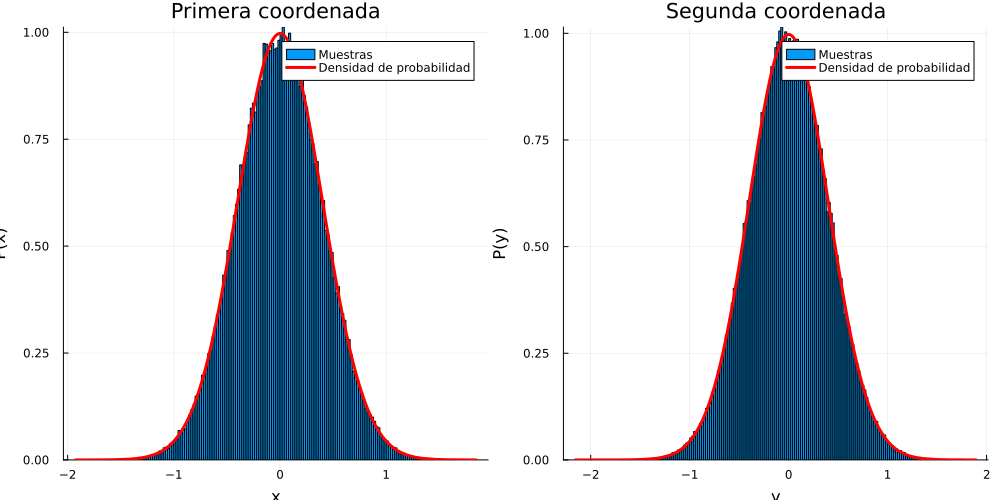

In [6]:
p(x) = 1/sqrt(2pi*0.16) * exp(-x^2/(2*0.16))
I2 = Matrix{Float64}(I, 2, 2)

rng = MersenneTwister(39)
dist = MvNormal(zeros(2), 0.16*I2)
print("La desviación estándar de la distribución es ")
println(std(dist))
normales1 = Array{Float64}(undef, 200000)
normales2 = Array{Float64}(undef, 200000)
for k in 1:200000
    η = rand(rng, dist)
    normales1[k] = η[1]
    normales2[k] = η[2]
end
p1 = histogram(normales1, normalize=:pdf, label = "Muestras")
plot!(p, label="Densidad de probabilidad", lw=3, color=:red)
title!("Primera coordenada")
xlabel!("x")
ylabel!("P(x)")

p2 = histogram(normales2, normalize=:pdf, label = "Muestras")
plot!(p, label="Densidad de probabilidad", lw=3, color=:red)
title!("Segunda coordenada")
xlabel!("y")
ylabel!("P(y)")

plot(p1,p2, size = (1000,500))

## **Euler-Maruyama**

In [7]:
# Constants and matrices
α_d, β_d      = 35.3462, 0.0280        # fixed-effects diameter intercept & pull-back (Table 2 in the paper)
α_h, β_h      = 25.3301, 0.0396        # fixed-effects height intercept & pull-back (Table 2 in the paper)
σ11, σ12, σ22 = 2.3736, 0.6334, 0.3615  # mixed-effects diffusion entries (PD!). For the fixed ones,the matrix is singular
mu = [α_d, α_h]
gamma = Diagonal([β_d, β_h])
B = [σ11 σ12; σ12 σ22]


2×2 Matrix{Float64}:
 2.3736  0.6334
 0.6334  0.3615

In [4]:
# dist1 = MvNormal(zeros(2), exp(gamma))
# dist2 = MvNormal(zeros(2), Q)
# println(dist1.Σ)
# println(dist2.Σ)
# normales1 = Array{Float64}(undef, 200000)
# normales2 = Array{Float64}(undef, 200000)
# sqQ = sqrt(Q)
# for k in 1:200000
    # η1 = rand(rng, dist1)
    # η2 = rand(rng, dist2)
    # normales1[k] = (η1)[1]
    # normales2[k] = (η1)[2]
# end
# 
# histogram2d(normales1, normales2)
# histogram!(normales2)

LoadError: UndefVarError: `Q` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

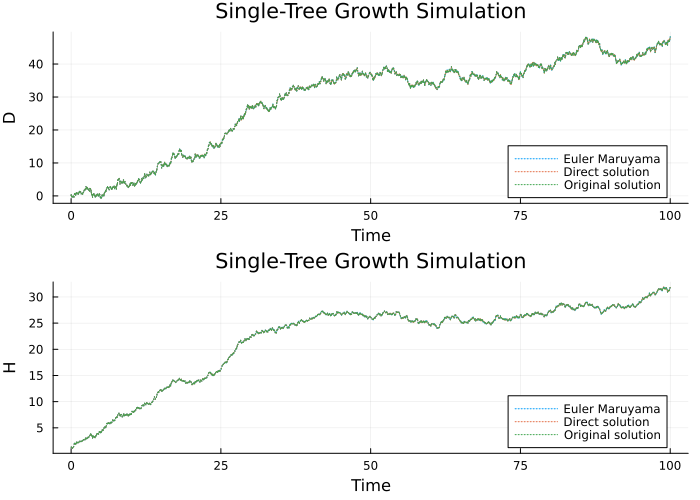

In [8]:
# Basic simulation info
T       = 100 # time horizon
n       = 5000 # number of steps
Δt      = T/n # time step
x0      = [0.1, 1.3]  # start (diameter, height) at t0
sqB     = sqrt(B)

# Allocate & initialize
EM = Array{Float64}(undef, 2, n+1) # Euler-Maruyama scheme
EM[:,1] .= x0
DS = Array{Float64}(undef, 2, n+1) # direct solution
DS[:,1] .= x0
OS = Array{Float64}(undef, 2, n+1) # original scheme
OS[:,1] .= x0
BI = [0, 0] # brownian integral

# Simulate forward from k=1..n between Euler-Maruyama, the direct solution and the original simulations
F = exp(-gamma * Δt)
Q = [ σ11*(1-exp(-2β_d*Δt))/(2β_d)     σ12*(1-exp(-(β_d+β_h)*Δt))/(β_d+β_h);
      σ12*(1-exp(-(β_d+β_h)*Δt))/(β_d+β_h)   σ22*(1-exp(-2β_h*Δt))/(2β_h) ]

rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt*I2)
for k in 1:n
    η = rand(rng, dist)
    EM[:,k+1] = EM[:,k] + gamma*(mu - EM[:,k])*Δt .+ sqB * η
    BI += exp(gamma*Δt*(k-1)) * sqB * η
    DS[:,k+1] = mu .+ exp(-gamma*Δt*k)*(x0 .- mu .+ BI)
    OS[:,k+1] = mu .+ F*(OS[:,k] - mu) .+ sqrt(Q/Δt)*η
end

# Plot the single trajectory
t = 0:Δt:T

p1 = plot(t, EM[1,:], label="Euler Maruyama", xlabel="Time", ylabel="D", legend=:bottomright, linestyle=:dot)
plot!(t, DS[1,:], label="Direct solution", xlabel="Time", ylabel="D", legend=:bottomright, linestyle=:dot)
plot!(t, OS[1,:], label="Original solution", xlabel="Time", ylabel="D", legend=:bottomright, linestyle=:dot)
p2 = plot(t, EM[2,:], label="Euler Maruyama", xlabel="Time", ylabel="H", legend=:bottomright, linestyle=:dot)
plot!(t, DS[2,:], label="Direct solution", xlabel="Time", ylabel="H", legend=:bottomright, linestyle=:dot)
plot!(t, OS[2,:], label="Original solution", xlabel="Time", ylabel="H", legend=:bottomright, linestyle=:dot)
plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

In [ ]:
samples = 20000

# Allocate & initialize
Xs = Array{Float64, 3}(undef, 2, n+1, samples)
X0 = reshape(repeat(x0, samples), (2, samples))
Xs[:,1,:] .= X0

# Simulate forward from k=1..n
rng = MersenneTwister(39)
dist = MvNormal(zeros(2), Δt*I2)
for k in 1:n
    for j in 1:samples
        η = rand(rng, dist)
        Xs[:,k+1,j] = Xs[:,k,j] .+ gamma*(mu .- Xs[:,k,j])*Δt .+ sqB * η
    end
end

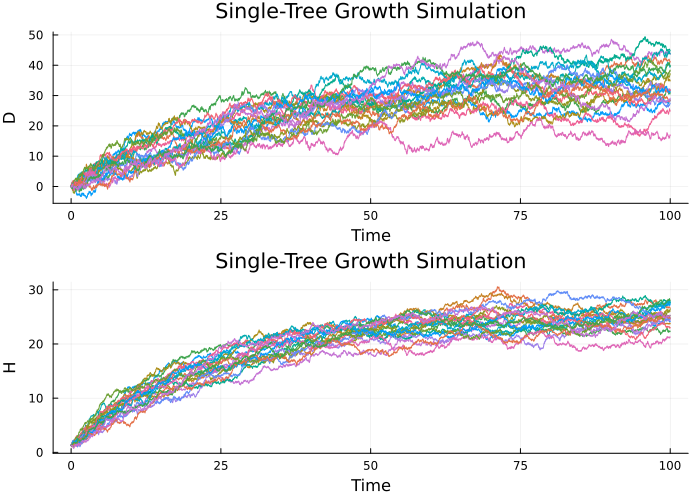

In [10]:
# 6. Plot the trajectories
t = 0:Δt:T
 
p1 = plot(t, Xs[1,:,1:20], xlabel="Time", ylabel="D", legend=false)
p2 = plot(t, Xs[2,:,1:20], xlabel="Time", ylabel="H", legend=false)
 
plot(p1, p2, layout=(2,1), size=(700,500), title="Single‐Tree Growth Simulation")

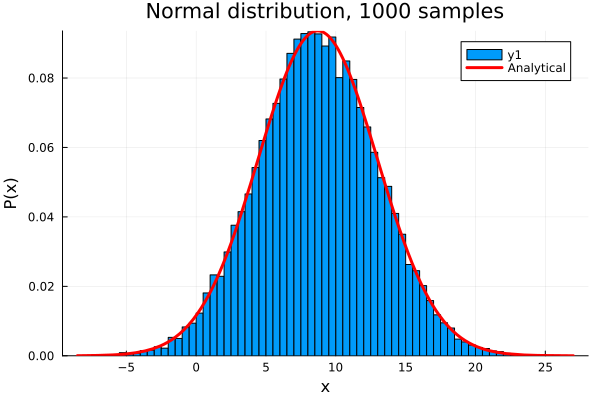

In [11]:
d0, h0 = x0

tt = 10
muu(t) = α_d + (d0 - α_d)*exp(-β_d*t) 
sigmasq(t) = σ11*(1 - exp(-2*β_d*t))/2β_d
p(x) = 1/sqrt(2pi*sigmasq(tt)) * exp(-(x-muu(tt))^2/(2*sigmasq(tt)))

histogram(Xs[1,50*tt,:], normalize=:pdf)
plot!(p, label="Analytical", lw=3, color=:red)
title!("Normal distribution, 1000 samples")
xlabel!("x")
ylabel!("P(x)")

In [12]:
site_idx = mean(sort(Xs[2,40*50,:])[20000-1000:20000])

24.78577058236034

## **''Markovianización'' del conjunto de estados**

Recuento del número de trayectorias

In [42]:
t_samples = floor(Int,5/Δt)
Ys = max.(floor.(Int, Xs[:,1:t_samples:end,:]/5),0)

# Creation of all possible transitions
key_list = [([d1,h1], [d2,h2]) for d1 in 0:12, d2 in 0:12, h1 in 0:6, h2 in 0:6]
# Dictionary counting the numbers of transitions
tr_dict = Dict(key => 0 for key in key_list)

# Counting the transitions according to the simplification of the model
for i in 1:samples
    for k in 1:size(Ys)[2]-1
        tr_dict[Ys[:,k,i],Ys[:,k+1,i]] += 1
    end
end

sumas_mc = Dict()
valid_idx = []
for d1 in 0:9
    for h1 in 0:6
        s = sum(tr_dict[[d1,h1],[d2,h2]] for d2 in 0:9, h2 in 0:6)
        # omitir estados muy poco visitados
        if s >= 200 
            sumas_mc[[d1,h1]] = s
            push!(valid_idx, [d1,h1])
        end
    end
end

Matriz de transición

In [41]:
valid_idx

29-element Vector{Any}:
 [0, 0]
 [0, 1]
 [0, 2]
 [1, 0]
 [1, 1]
 [1, 2]
 [1, 3]
 [2, 1]
 [2, 2]
 [2, 3]
 [2, 4]
 [3, 2]
 [3, 3]
 ⋮
 [4, 5]
 [5, 3]
 [5, 4]
 [5, 5]
 [6, 3]
 [6, 4]
 [6, 5]
 [7, 4]
 [7, 5]
 [8, 4]
 [8, 5]
 [9, 5]

In [60]:
mc_dict = Dict()
for ik in valid_idx
    s = sumas_mc[ik]
    t = 0
    print("Estado de partida: ")
    println(ik)
    println(" ")
    for jl in valid_idx
        mc_dict[ik,jl] = trunc(round(tr_dict[ik,jl]/s; digits=4); digits = 2)
        if mc_dict[ik,jl] > 0
            print("Estado de llegada: ")
            print(jl)
            print(", prob. de transición = ")
            println(mc_dict[ik,jl])
            t += mc_dict[ik,jl]
        end
    end
    print("Suma de probs. de transición = ")
    println(t)
    println(" ")
    println("------------------")
    println(" ")
end

Estado de partida: [0, 0]
 
Estado de llegada: [0, 0], prob. de transición = 0.21
Estado de llegada: [0, 1], prob. de transición = 0.29
Estado de llegada: [1, 0], prob. de transición = 0.03
Estado de llegada: [1, 1], prob. de transición = 0.38
Estado de llegada: [2, 1], prob. de transición = 0.05
Suma de probs. de transición = 0.9600000000000001
 
------------------
 
Estado de partida: [0, 1]
 
Estado de llegada: [0, 1], prob. de transición = 0.19
Estado de llegada: [0, 2], prob. de transición = 0.07
Estado de llegada: [1, 1], prob. de transición = 0.26
Estado de llegada: [1, 2], prob. de transición = 0.25
Estado de llegada: [2, 1], prob. de transición = 0.04
Estado de llegada: [2, 2], prob. de transición = 0.15
Suma de probs. de transición = 0.9600000000000001
 
------------------
 
Estado de partida: [0, 2]
 
Estado de llegada: [0, 2], prob. de transición = 0.21
Estado de llegada: [1, 2], prob. de transición = 0.39
Estado de llegada: [1, 3], prob. de transición = 0.14
Estado de lleg

# **Extensión del modelo Markovianizado**

## **Creación del modelo**

In [66]:
N = length(valid_idx)

x0_test = zeros(N)
x0_test[1] = 1
f_test = Float64[]
BAs = Float64[]
rel = Dict()
for i in 1:N
    push!(f_test, 1)
    i_d, i_h = valid_idx[i]
    rel[i] = [i_d, i_h]
    d_i = 5*i_d + 2.5
    push!(BAs, pi*d_i^2/40000) 
end

tr_mtx = zeros(N,N)
for i in 1:N
    for j in 1:N
        tr_mtx[i,j] = mc_dict[(rel[i],rel[j])]
    end
end

In [334]:
a0 = -3.552
a1 = -0.062 
a3 = 0.016

function p_rec(BA)
    return (1 + e^-(a0 + a3 + a1*BA))^-1
end

function dp_rec(BA)
    return a1 / (2*cosh(a0 + a3 + a1*BA) + 2)
end

b0 = 67.152
b1 = -0.076

function c_rec(BA)
    return b0 * BA^b1
end

function dc_rec(BA)
    return b0 * b1*BA^(b1-1)
end

dc_rec (generic function with 1 method)

In [335]:
new_model1 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:nx], u <= as1_x[k]*TV + bs1_x[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [336]:
new_model2 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:ny], u <= as1_y[k]*TV + bs1_y[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [337]:
new_model3 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:nx-1], u <= as2_x[k]*TV + bs2_x[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [291]:
new_model4 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_test[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum((x[t].in - c[t])*tr_mtx[t,s] for t in 1:n) # Markovian transitions between set_attributes
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
        [k = 1:ny-1], u <= as2_y[k]*TV + bs2_y[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

A policy graph with 1 nodes.
 Node indices: 1


In [338]:
SDDP.train(new_model1, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model1, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model1)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [2519, 2519]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     sol

In [293]:
SDDP.train(new_model2, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model2, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model2)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [119, 119]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 2e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [5e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solve

In [294]:
SDDP.train(new_model3, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model3, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model3)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [2518, 2518]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [1e+00, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     sol

In [295]:
SDDP.train(new_model4, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(new_model4, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(new_model4)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [60, 60]
  AffExpr in MOI.EqualTo{Float64}         : [20, 20]
  AffExpr in MOI.LessThan{Float64}        : [118, 118]
  VariableRef in MOI.GreaterThan{Float64} : [40, 40]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [2e-03, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solve

# **Extensión del modelo con regeneración**

El modelo de regeneración a usar corresponde a aquel trabajado en Bollandsas et al, en el cual en cada etapa, el número de árboles de la especie $i\in\{1,\ldots, N\}$ de la primera clase de altura y diámetro corresponde al producto $\pi_i \times CR_i$, con 
- $\pi_i = \frac{e^{\alpha_{i0} + \alpha_{i1} BA + \alpha_{i2} SI + \alpha_{i3} PBA}}{1 + e^{\alpha_{i0} + \alpha_{i1} BA + \alpha_{i2} SI + \alpha_{i3} PBA}}$
- $CR_i = \beta_{i0} BA^{\beta_{i1}} SI^{\beta_{i2}} PBA^{\beta_{i3}}$

En particular, se asume que el área en la cual se trabaja es exactamente una hectárea, el site index SI corresponde a la altura promedio de los árboles dominantes de 40 años y el PBA es idéntico a 1 al existir una única especie.

In [134]:
a_10, a_11, a_12, a_13 = (-2.291, -0.018, 0.066, 0.019)
a_20, a_21, a_22, a_23 = (-3.552, -0.062, 0, 0.031)
a_30, a_31, a_32, a_33 = (-0.904, -0.037, 0, 0.016)
a_40, a_41, a_42, a_43 = (-3.438, -0.029, 0.123, 0.048)

SI = 22 #DE JUGUETE

function pi_1(BA)
    return 1/(1 + exp(-(a_10 + a_11*BA + a_12*SI + a_13)))
end
function pi_2(BA)
    return 1/(1 + exp(-(a_20 + a_21*BA + a_22*SI + a_23)))
end
function pi_3(BA)
    return 1/(1 + exp(-(a_30 + a_31*BA + a_32*SI + a_33)))
end
function pi_4(BA)
    return 1/(1 + exp(-(a_40 + a_41*BA + a_42*SI + a_43)))
end

plot(pi_1, 0,80)
plot!(pi_2, 0,80)
plot!(pi_3, 0,80)
plot!(pi_4, 0,80)

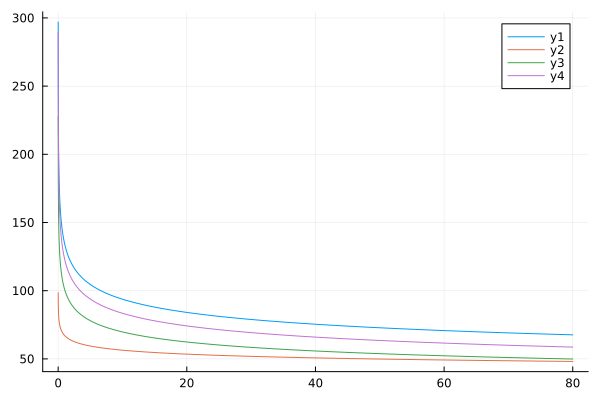

In [135]:
b_10, b_11, b_12 = (43.142, -0.157, 0.368)
b_20, b_21, b_22 = (67.152, -0.076, 0)
b_30, b_31, b_32 = (64.943, -0.161, 0.143)
b_40, b_41, b_42 = (31.438, -0.1695, 0.442)

SI = 22 #DE JUGUETE

function CR_1(BA)
    return b_10* BA^b_11 * SI^b_12
end
function CR_2(BA)
    return b_20* BA^b_21 * SI^b_22
end
function CR_3(BA)
    return b_30* BA^b_31 * SI^b_32
end
function CR_4(BA)
    return b_40* BA^b_41 * SI^b_42
end

plot(CR_1, 0,80)
plot!(CR_2, 0,80)
plot!(CR_3, 0,80)
plot!(CR_4, 0,80)

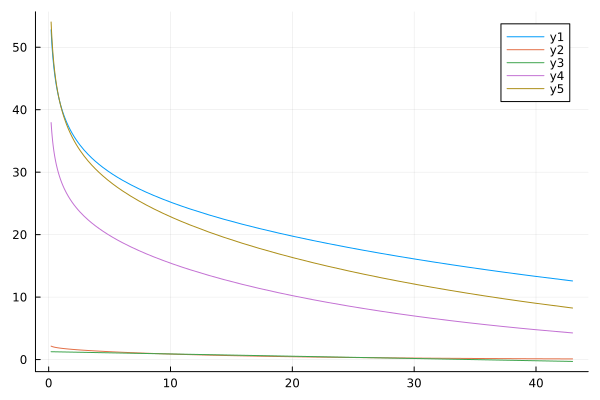

In [172]:
function d1(BA)
    return pi_1(BA)*CR_1(BA+0.001)
end

function d2(BA)
    return pi_2(BA)*CR_2(BA+0.001)
end

function d2_app(BA)
    x1, y1 = 5, d2(5)
    x2, y2 = 35, d2(35)
    return BA*(y2 - y1)/(x2 -x1) + y1
end

function d3(BA)
    return pi_3(BA)*CR_3(BA+0.001)
end

function d4(BA)
    return pi_4(BA)*CR_4(BA+0.001)
end
plot(d1, 0.2,43)
plot!(d2, 0.2,43)
plot!(d2_app, 0.2, 43)
plot!(d3, 0.2,43)
plot!(d4, 0.2,43)

In [137]:
386*37.5^2*pi/40000

42.63239405691774

In [138]:
N_por_diam = 18.4/sum(d^2*pi/40000 for d in 2.5:5:37.5)

x0_reg = zeros(N)
x0_reg[1] = N_por_diam*7
UB = 1000

f_reg = Float64[]
for i in 1:n
    push!(f_reg, 0.01)
end

In [139]:
final_mode11 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0_reg[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, BA >= 0) # basal area
    @variable(sp, TV >= 0) # Timber volume
    @variable(sp, u >= 0) #slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
    @constraints(sp, begin
        [s = 2:n], x[s].out == sum(tr_mtx[t,s]*(x[t].in - c[t]) for t in 1:n) # Markovian transitions between set_attributes
        sum(BAs[s] * x[s].out for s in 2:n) == BA # basal area
        sum(f_test[s] * c[s] for s in 1:n) == TV # timber volume
        x[1].out == d2_app(BA)
        [k = 1:ny-1], u <= as2_y[k]*TV + bs2_y[k] #forces u to be approx. TV^(1-α)/(1-α)
    end)
    @stageobjective(sp, u)
end

LoadError: UndefVarError: `graph` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
SDDP.train(final_mode11, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(final_mode11, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
lower_bound = SDDP.calculate_bound(final_mode11)
println("Confidence interval: ", μ, " ± ", ci)
println("Lower bound: ", round(lower_bound, digits = 2))

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 19
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [61, 61]
  AffExpr in MOI.EqualTo{Float64}         : [21, 21]
  AffExpr in MOI.LessThan{Float64}        : [199, 199]
  VariableRef in MOI.GreaterThan{Float64} : [41, 41]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [5e-04, 1e+00]
  objective range  [1e+00, 1e+00]
  bounds range     [1e+03, 1e+03]
  rhs range        [9e-01, 5e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solve

# **Minimum viable product**

In [ ]:
N = length(valid_idx)

tr_mtx = zeros(N,N)
for i in 1:N
    for j in 1:N
        tr_mtx[i,j] = mc_dict[(rel[i],rel[j])]
    end
end

## **Sin función de regeneración**

In [189]:
Z =  Array{Float64}(undef, 100, N) 
Z[1,:] = transpose(x0_reg)
for k in 2:100
    Z[k,:] = transpose(Z[k-1,:])*tr_mtx
end 
xxis = 50:1000
plot(Z .+ 1, yaxis=:log10, legend = false)

## **Con función de regeneración, sin tala:**

Masa total = 503.7314107685215
Masa total = 523.7661107648379
Masa total = 533.8012310978557
Masa total = 537.3577089620729
Masa total = 536.2766743522152
Masa total = 531.840666131786
Masa total = 524.9481119067823
Masa total = 516.2585801498279
Masa total = 506.29136325851334
Masa total = 495.470843981438
Masa total = 484.14502852675133
Masa total = 472.5958940437091
Masa total = 461.04831261234045
Masa total = 449.67868577092503
Masa total = 438.6229513080252
Masa total = 427.9836188599209
Masa total = 417.83573774486933
Masa total = 408.2318681596954
Masa total = 399.2061942243097
Masa total = 390.77792595763907
Masa total = 382.9541212276131
Masa total = 375.732036208486
Masa total = 369.1010914782713
Masa total = 363.04452292430045
Masa total = 357.5407722767327
Masa total = 352.5646608459856
Masa total = 348.0883812744344
Masa total = 344.0823352750616
Masa total = 340.51583998383575
Masa total = 337.3577213651301
Masa total = 334.57680982776475
Masa total = 332.1423506404508
Ma

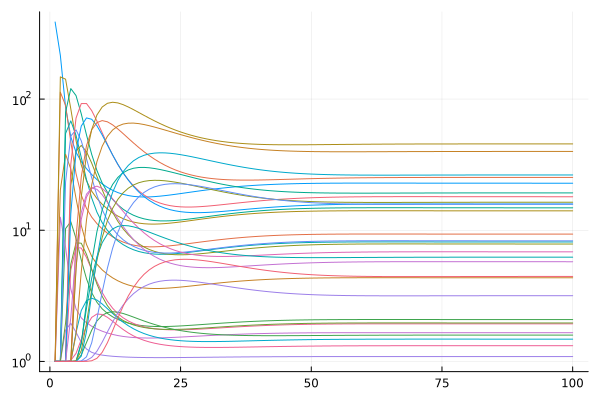

In [202]:
Z =  Array{Float64}(undef, 100, N) 
Z[1,:] = transpose(x0_reg)
for k in 2:100
    BA = sum(BAs[s] * Z[k-1,s] for s in 2:N)
    Z[k,:] = transpose(Z[k-1,:])*tr_mtx
    Z[k,1] += d4(BA)
    print("Masa total = ")
    println(sum(Z[k,:]))
end 
plot(Z .+ 1, yaxis=:log10, legend = false)

## **Con función de regeneración, con tala:**

In [200]:
frac_tala = [1, 1, 1, 1, 1,
    0.8, 0.8, 0.8, 0.8, 0.8,
    0.6, 0.6, 0.6, 0.6, 0.6,
    0.4, 0.4, 0.4, 0.4, 0.4,
    0.4, 0.4, 0.4, 0.4, 0.4,
    0.4, 0.4, 0.4, 0.4, 0.4,
]

30-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 0.8
 0.8
 0.8
 0.8
 0.8
 0.6
 0.6
 0.6
 ⋮
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4
 0.4

Masa total = 499.87274598353594
Masa total = 477.9250621193589
Masa total = 414.43563227888126
Masa total = 337.3507005362104
Masa total = 268.2180861725357
Masa total = 217.03057149574656
Masa total = 184.5804830758934
Masa total = 167.1442520168496
Masa total = 159.93030364986632
Masa total = 158.72742907283796
Masa total = 160.42204164325372
Masa total = 163.00976040722514
Masa total = 165.40164646110577
Masa total = 167.15658698269957
Masa total = 168.22247480952262
Masa total = 168.73364387977554
Masa total = 168.8776880979711
Masa total = 168.8232740996133
Masa total = 168.6918767805148
Masa total = 168.55585021476344
Masa total = 168.4488384747483
Masa total = 168.3793507934317
Masa total = 168.34263572008862
Masa total = 168.32906144611388
Masa total = 168.3290029499593
Masa total = 168.33503909262242
Masa total = 168.34243716400832
Masa total = 168.3487562376165
Masa total = 168.35314473033444
Masa total = 168.35566093952863
Masa total = 168.35675925299782
Masa total = 168.356

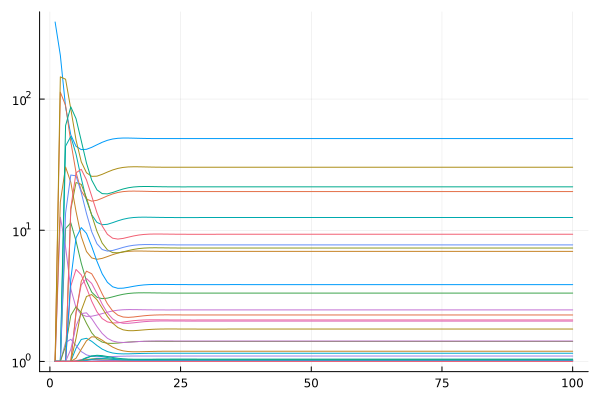

In [ ]:
Z =  Array{Float64}(undef, 100, N) 
Z[1,:] = transpose(x0_reg)
for k in 2:100
    BA = sum(BAs[s] * Z[k-1,s] for s in 2:N)
    Z[k,:] = transpose(Z[k-1,:])*tr_mtx .*transpose(frac_tala)
    Z[k,1] += d4(BA)
    print("Masa total = ")
    println(sum(Z[k,:]))
end 
plot(Z .+ 1, yaxis=:log10, legend = false)